# Kubeflow test flakiness report
This notebook reports kubeflow test flakiness. We leverqe [kettle](https://github.com/kubernetes/test-infra/tree/master/kettle) which uploads test metadata into bigquery upon publishing in GCS buckets via [Prow](https://github.com/kubernetes/test-infra/tree/master/prow). We also slightly modify flakiness queries used in k8s infra-test [metrics](https://github.com/kubernetes/test-infra/tree/master/metrics) to compute daily flakiness metrics and job fields for kubeflow test jobs as follows:  

-  __job__: name of the test e.g., pr:kubeflow-presubmit (if a test is triggered by a pr, kettle adds "pr:" to the beginning of the job name.)
-  __start_date__: test start date
-  __runs__: total number of test runs during the day of the start date 
-  __flakes__: if different runs of a given commit report different result (some failed and some (one) passed), we say that flake happens for that commit. __flakes__ metric points to the number of flakes for all commits of the job during the day (start date) 
-  __passed__: total number of times that the job runs successfully.  
-  __failed__: total number of distinct commits which do not have not any successful run 
-  __flake_rate__: the ratio of number of flakes over the number of distinct commits
-  __commit_consistency__: one minus __flake_rate__
-  __build_consistency__: the ratio of useful runs over the total runs. If a job flakes then the last successful run is a useful run, otherwise all runs are useful. 
-  __flaky_runs__: __runs__ - __passed__ - __failed__




currently we compute the above for kubeflow prs which trigger presubmit tests. Later we will expand it for all types of kubeflow tests.

__Caveat__: flakiness metrics are correct for commits for which  a conclusion is made i.e., either it is passed or failed and is reflected in the logs. If a commit failed and future runs reveal that the failure was a flake, it won't be reflected in the current flakiness metrics. Therefore, we should look at flakiness report for a relatively long time (e.g., a week).    


In [185]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Compute daily flakiness of kubeflow presubmit tests

In [186]:
%%bigquery daily_flakiness
select 
    job,
    start_date,
    round(sum(if(flaked=1,passed,runs))/sum(runs),3) build_consistency,
    round(1-sum(flaked)/count(distinct commit),3) commit_consistency,
    round (sum(flaked)/count(distinct commit),3) flake_rate,
    sum(flaked) flakes,
    sum(runs) runs,
    sum(passed) passed,
    sum(flaky_runs) flaky_runs,
    sum(failed) failed
  from ( /* Determine whether a (job, pr-num, commit) flaked */
    select
      job,
      start_date,
      num,
      commit,
      if(passed = runs or passed = 0, 0, 1) flaked,
      if(passed = runs or passed = 0, 0, runs-passed) flaky_runs, 
      if(passed = 0, runs, 0) failed, 
      passed,
      CAST(runs as INT64) runs
    from (
      select /* Count the runs and passes for each (job, pr-num, commit) */
        max(start_date) start_date,
        num,
        commit,
        sum(if(result='SUCCESS',1,0)) passed,
        count(result) runs,
        job
      from (
        SELECT /* all runs of any job for the past week, noting the commit and whether it passed */
          job,
          regexp_extract(path, r'pull/(\d+)') as num, /* pr number */
          regexp_extract(m.value, r'[^,]+,\d+:([a-f0-9]+)"') commit, /* extract the first commit id from the repo flag */
          EXTRACT(DATE FROM started) start_date,    
          result
        FROM `k8s-gubernator.build.all` , UNNEST(metadata) as m
        where
          started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 672 HOUR)
          and (m.key = "repos") and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
      )
      group by job, num, commit
    )
  )
  group by job, start_date
  order by
    flakes desc,
    build_consistency,
    commit_consistency,
    job

,job,start_date,build_consistency,commit_consistency,flake_rate,flakes,runs,passed,flaky_runs,failed
0,pr:kubeflow-presubmit,2019-04-19,0.614,0.591,0.409,9,44,17,17,10
1,pr:kubeflow-presubmit,2019-04-23,0.722,0.684,0.316,6,36,19,10,7
2,pr:kubeflow-tf-operator-presubmit,2019-04-23,0.500,0.250,0.750,3,12,4,6,2
3,pr:kubeflow-presubmit,2019-04-03,0.857,0.750,0.250,3,21,18,3,0
4,pr:kubeflow-presubmit,2019-04-05,0.900,0.850,0.150,3,30,22,3,5
5,pr:kubeflow-presubmit,2019-04-06,0.667,0.667,0.333,2,9,5,3,1
6,pr:kubeflow-presubmit,2019-04-10,0.842,0.846,0.154,2,19,4,3,12
7,pr:kubeflow-katib-presubmit,2019-04-22,0.500,0.000,1.000,1,2,1,1,0
8,pr:kubeflow-katib-presubmit,2019-04-02,0.500,0.000,1.000,1,2,1,1,0
9,pr:kubeflow-katib-presubmit,2019-04-09,0.500,0.000,1.000,1,2,1,1,0


# Daily flake rate  of all presubmit tests over time

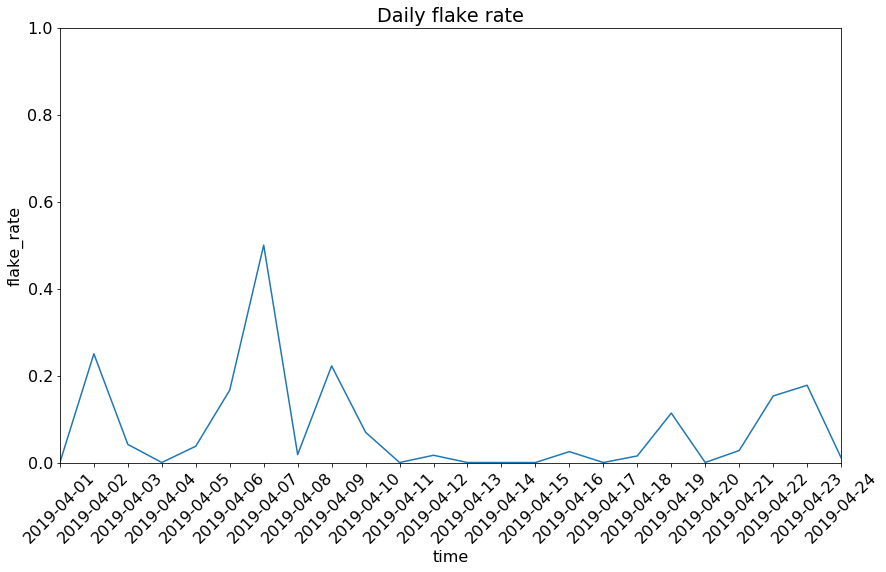

In [187]:
import pandas as pd
overal_flakes = pd.DataFrame(daily_flakiness).groupby("start_date",as_index=False).agg(
{ 'flake_rate':'mean',
  'flakes' :'sum',
   'runs' : 'sum'
})
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
matplotlib.rc('font', size=16)
ax=overal_flakes.flake_rate.plot(xticks=overal_flakes.index,figsize=(14,8), rot=45)
plt.title('Daily flake rate')
plt.xlabel('time')
plt.ylabel('flake_rate')
ax.set_xticklabels(overal_flakes['start_date'])
plt.ylim([0,1])

 

plt.show()


# Daily build and commit consistency of all presubmit tests
As illustreated by the plot, build_consistency and commit_consistency are expectedly corrolated. 
Note that build_consistency is computed with respect to the total number of runs whereas commit_consistency is computed with respect to distinct number of commits. This means that if number of flaky runs increases (i.e., runing retest) then build_consistency becomes lower than commit_consistency. 

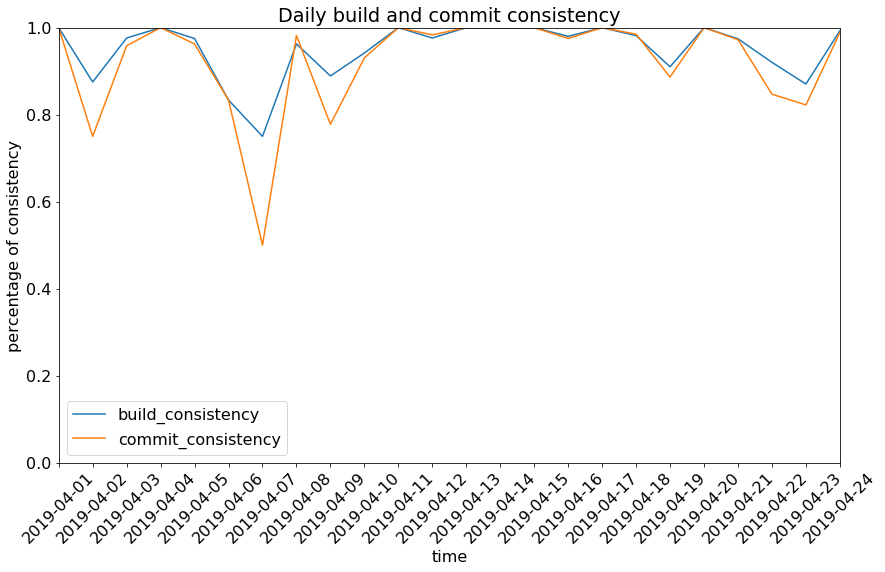

In [188]:
import pandas as pd
overal_consistency = pd.DataFrame(daily_flakiness).groupby("start_date",as_index=False).agg(
{ 'build_consistency':'mean',
  'commit_consistency' :'mean'
})
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
matplotlib.rc('font', size=16)
ax1=overal_consistency.build_consistency.plot(xticks=overal_consistency.index,figsize=(14,8), rot=45)
ax2=overal_consistency.commit_consistency.plot(xticks=overal_consistency.index,figsize=(14,8), rot=45)

plt.title('Daily build and commit consistency')
plt.xlabel('time')
plt.ylabel('percentage of consistency')
ax1.set_xticklabels(overal_consistency['start_date'])
plt.legend()
plt.ylim([0,1])

plt.show()

# Flakiness per job

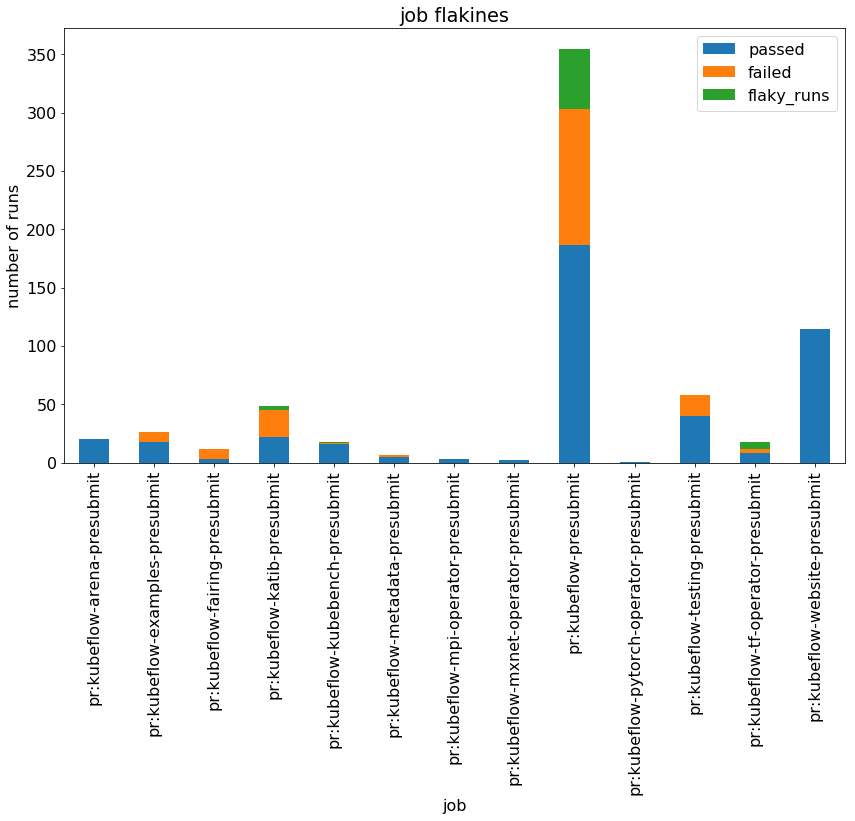

In [189]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

job_flakiness=pd.DataFrame(daily_flakiness).groupby("job",as_index=False).agg(
{ 'passed':'sum',
  'failed' :'sum',
   'flaky_runs' : 'sum'
})
matplotlib.rc('font', size=16)
ax=job_flakiness[['passed','failed','flaky_runs']].plot(kind='bar', stacked=True, xticks=job_flakiness.index, figsize=(14,8), rot=90)
ax.set_xticklabels(job_flakiness['job'])
plt.title('job flakines')
plt.xlabel('job')
plt.ylabel('number of runs')
plt.show()

# Overal failure rate per test type

Below we computer failure rate per junit tests as well as workflow tests.
Kettle stores Junit mtadata in the column "test".
Workflow tests results are stored in the column "metadata" whcih is a map. if key ends with "-phase", the key contains workflow test name and the value indicates whether it is succeeded or failed. 

* Caveat: For kubeflow-presubmit jobs, the test columns sometimes have the information of workflow tests which looks like a bug. For the folllowing results, such data are filtered out.  


# Overal failure rate per Junit tests

In [190]:
%%bigquery teststats
CREATE TEMP FUNCTION removeFirstChar(x STRING)
RETURNS STRING
LANGUAGE js AS """
  if (x.charAt(0) == '-') {
    x=x.substr(1);
  }
  return x;
""";
SELECT testname,runs,failures,filurepercentage
FROM(
SELECT
  removeFirstChar(t.name) testname,
  SUM(CASE WHEN t.failed=TRUE THEN 1 ELSE 0 END) failures,
  COUNT(*) runs,
  ROUND(SUM(CASE WHEN t.failed=TRUE THEN 1 ELSE 0 END)/COUNT(*)*100, 2) filurepercentage
FROM
 `k8s-gubernator.build.all`, UNNEST(test) as t
WHERE
   job LIKE '%kubeflow-presubmit%'
GROUP BY
  testname
) WHERE testname not LIKE '%kubeflow-presubmit%'
order by filurepercentage DESC
    

,testname,runs,failures,filurepercentage
0,deploy-kubeflow-deploy_model-inceptionGpu,1,1,100.00
1,deploy-kubeflow-deploy_model-gpu,1,1,100.00
2,deploy-kubeflow-deploy_model-inceptionCpu,1,1,100.00
3,github.com/kubeflow/kubeflow/bootstrap/v2/pkg/...,1,1,100.00
4,deploy-kubeflow-deploy_sparkjob-spark-job,11,8,72.73
5,deploy-kubeflow-deploy_pytorchjob-inception-cpu,3,2,66.67
6,test_katib,7,4,57.14
7,deploy-kubeflow-deploy_pytorchjob-inception-gpu,2,1,50.00
8,test-jsonnet-format,4,1,25.00
9,deploy_model-mnist-gpu,17,4,23.53


# Overal failure rate per workflow phase tests

In [191]:
%%bigquery teststats
CREATE TEMP FUNCTION getWorkflowTestName(x STRING)
RETURNS STRING
LANGUAGE js AS """
  var r=/\\d/;
  var y=x.replace("-e2e","-endtoend");
  var fd=r.exec(y);
  y=y.substring(0, y.indexOf(fd) - 1);
  y=y.replace("-endtoend","-e2e");
  return y;
""";
Select 
    testname,
    SUM(CASE WHEN mvalue ="Succeeded" THEN 0 ELSE 1 END) failures,
    COUNT(*) runs,
    ROUND(SUM(CASE WHEN mvalue ="Succeeded" THEN 0 ELSE 1 END)/COUNT(*)*100, 2) filurepercentage
From(
    Select getWorkflowTestName(mkey) testname,mvalue
    FROM(
        SELECT m.key mkey, m.value mvalue
        FROM
         `k8s-gubernator.build.all`,UNNEST(metadata) as m
        WHERE
           job LIKE '%kubeflow-presubmit%' and ENDS_WITH(m.key, "-phase")
    )
)
GROUP BY testname
ORDER BY filurepercentage DESC

,testname,failures,runs,filurepercentage
0,kubeflow-presubmit-jupyter-web-app-release,2,2,100.00
1,kubeflow-presubmit-deployapp,30,35,85.71
2,kubeflow-presubmit-kfctl-go,218,401,54.36
3,kubeflow-presubmit-kfctl-go-basic-auth,106,224,47.32
4,kubeflow-presubmit-kfctl-go-iap-istio,34,76,44.74
5,kubeflow-presubmit-kfctl-beta,120,323,37.15
6,kubeflow-presubmit-kubeflow-gke-deploy,131,370,35.41
7,kubeflow-presubmit-tf-notebook-release,160,454,35.24
8,kubeflow-presubmit-kfctl,1089,3112,34.99
9,kubeflow-presubmit-kfctl-go-iap,120,363,33.06


# Flakiness per junit tests

following are list of daily flakiness metrics
- testname: junit test name
- flakes: number of commits whcih has flakes
- runs: total number of runs
- failed: total number of times that test failed
- passed: total number of times that the test passed
- flake_failures: number of flake failures, i.e, test passed in the same commit
- actual_failures: number of actual failures (test nerver passed in the same commit)
- flake_rate: the ratio of flake_failures over runs
- failure_rate: the ratio of sum of flake_failures and actual_failures over runs    
    

In [192]:
%%bigquery junit_daily_flakes
CREATE TEMP FUNCTION removeFirstChar(x STRING)
RETURNS STRING
LANGUAGE js AS """
  if (x.charAt(0) == '-') {
    x=x.substr(1);
  }
  return x;
""";
SELECT
    testname,
    sum(runs) runs,
    sum(flake_failures)+sum(actual_failures) failed,
    sum(runs) - sum(flake_failures)-sum(actual_failures) passed,
    start_date,
    sum(flake) flakes,
    sum(flake_failures) flake_failures,
    sum(actual_failures) actual_failures,
    round(sum(flake_failures)/sum(runs), 3) flake_rate,
    round(sum(actual_failures)/sum(runs), 3) failure_rate
FROM(
       SELECT
            testname,
            runs,
            start_date,
            (CASE WHEN failures>0 AND passes>0 THEN 1 ELSE 0 END) flake,
            (CASE WHEN failures>0 AND passes>0 THEN failures ELSE 0 END) flake_failures,
            (CASE WHEN failures>0 AND passes>0 THEN 0 ELSE failures END) actual_failures 
        FROM(
                SELECT  /* collect stats per (commit, testname)*/ 
                    removeFirstChar(t.name) testname,
                    SUM(CASE WHEN t.failed=TRUE THEN 1 ELSE 0 END) failures,
                    SUM(CASE WHEN t.failed=TRUE THEN 0 ELSE 1 END) passes,
                    COUNT(*) runs,
                    max(start_date) start_date, 
                    regexp_extract(commit, r'[^,]+,\d+:([a-f0-9]+)"') commit /* extract the first commit id from the repo flag */  
                FROM( /* collect kubeflow commit rows */    
                        SELECT   
                            m.value commit,
                            test,
                            job,
                            EXTRACT(DATE FROM started) start_date
                        FROM
                            `k8s-gubernator.build.all`, UNNEST(metadata) as m
                        WHERE
                             job LIKE '%kubeflow-presubmit%'
                             and started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 672 HOUR)
                             and (m.key = "repos") and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
                ), UNNEST(test) as t
                WHERE removeFirstChar(t.name) not LIKE '%kubeflow-presubmit%'  
                GROUP BY removeFirstChar(t.name),commit
        )
)
group by testname,start_date
order by flake_rate DESC



,testname,runs,failed,passed,start_date,flakes,flake_failures,actual_failures,flake_rate,failure_rate
0,tfserving-deploy_model-mnist-gpu,6,3,3,2019-04-17,1,3,0,0.500,0.000
1,test_kf_is_ready,9,3,6,2019-04-17,3,3,0,0.333,0.000
2,kfctl-deploy_argo-test-argo-deploy,3,1,2,2019-04-10,1,1,0,0.333,0.000
3,test_kf_is_ready,5,1,4,2019-04-20,1,1,0,0.200,0.000
4,test_kf_is_ready,18,4,14,2019-04-18,2,3,1,0.167,0.056
5,test_kf_is_ready,69,13,56,2019-04-19,6,10,3,0.145,0.043
6,test_profiles,7,1,6,2019-04-24,1,1,0,0.143,0.000
7,smoke-tfjob-gke,10,2,8,2019-04-18,1,1,1,0.100,0.100
8,smoke-tfjob-gke,10,1,9,2019-04-21,1,1,0,0.100,0.000
9,test_kf_is_ready,29,2,27,2019-04-22,2,2,0,0.069,0.000


# Flakiness per test name

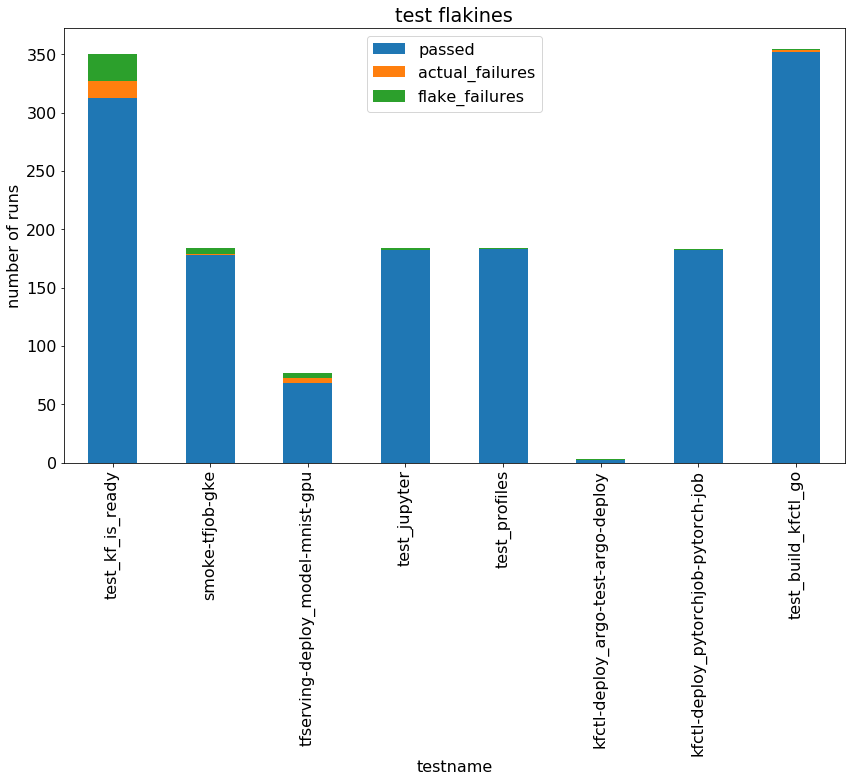

In [193]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

job_flakiness=pd.DataFrame(junit_daily_flakes).groupby("testname",as_index=False).agg(
{ 'passed':'sum',
  'actual_failures' :'sum',
   'flake_failures' : 'sum'
}).sort_values(by='flake_failures', ascending=False)
job_flakiness=job_flakiness.loc[(job_flakiness['flake_failures'] > 0)]
matplotlib.rc('font', size=16)
ax=job_flakiness[['passed','actual_failures','flake_failures']].plot(kind='bar', stacked=True, xticks=job_flakiness.index, figsize=(14,8), rot=90)
ax.set_xticklabels(job_flakiness['testname'])
plt.title('test flakines')
plt.xlabel('testname')
plt.ylabel('number of runs')
plt.show()

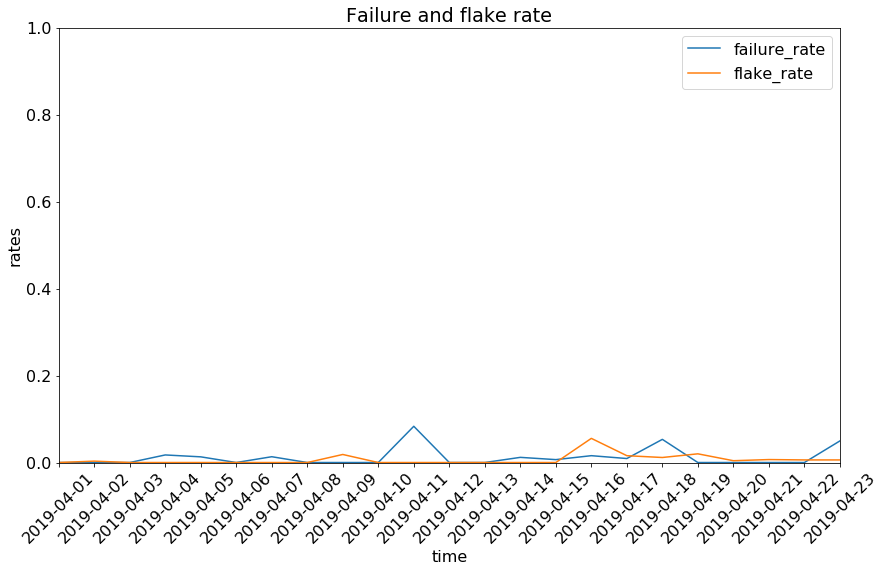

In [194]:
import pandas as pd
overal_failure = pd.DataFrame(junit_daily_flakes).groupby("start_date",as_index=False).agg(
{ 'flake_rate':'mean',
  'failure_rate' :'mean'
})
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
matplotlib.rc('font', size=16)
ax1=overal_failure.failure_rate.plot(xticks=overal_failure.index,figsize=(14,8), rot=45)
ax2=overal_failure.flake_rate.plot(xticks=overal_failure.index,figsize=(14,8), rot=45)

plt.title('Failure and flake rate')
plt.xlabel('time')
plt.ylabel('rates')
ax1.set_xticklabels(overal_consistency['start_date'])
plt.legend()
plt.ylim([0,1])

plt.show()